In [3]:
%%capture
!pip install fastai==1.0.61

## Setting workspace

In [1]:
import boto3
import os
import numpy as np
from pathlib import Path
from argparse import Namespace
from fastai.vision import *

args = Namespace(
    root = "/".join(os.getcwd().split("/")[:-1]),
    bucket_name = "sagemaker-us-west-2-430127992102",
    key = "ClassificationModel",
    image_dir = "fastai_data",
    data_dir = "dataset",
    tar_file_name = "dataset.tar.gz",
    model_dir = "model",
    tar_model_name = "model.tar.gz"
)
s3 = boto3.resource('s3')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
model_path = os.path.join(args.root, args.model_dir)
data_path = Path(os.path.join(args.root, args.data_dir))
labels = os.listdir(data_path)
data = ImageDataBunch.from_folder(data_path, valid_pct=0.2, bs=32, ds_tfms=get_transforms(), size=224, num_workers=4, no_check=True).normalize(imagenet_stats)
t_learner = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [23]:
t_learner.export(os.path.join(model_path,'teacker.pkl'))

papas_limon_margaritax39g 0.5753234028816223
{
   "probabilities": {
      "aguacate": 1.8544850490798126e-06,
      "arroz_basmati_castellanox1000g": 0.00010286063479725271,
      "arroz_blanco_carullax1000g": 4.009352778666653e-06,
      "arroz_vitamor_dianax500g": 1.5244871065078769e-05,
      "chicharron_americano_jacksx15g": 0.003818508703261614,
      "coca_cola_originalx250ml": 1.6783469618530944e-05,
      "coca_cola_originalx400ml": 0.004235938657075167,
      "mango_tommy": 2.7752275855164044e-06,
      "maracuya": 3.882975306623848e-06,
      "pan_de_queso_la_frontera": 0.3734644949436188,
      "pan_mantequilla_la_fronterax55g": 0.04216081649065018,
      "papas_limon_margarita_packeconomicox300g": 9.842513827607036e-05,
      "papas_limon_margaritax105g": 0.00019764919125009328,
      "papas_limon_margaritax110g": 8.717032324057072e-05,
      "papas_limon_margaritax39g": 0.5753234028816223,
      "spagheti_barilla": 8.510791667504236e-05,
      "yogurt_alpina_finesse_fresa

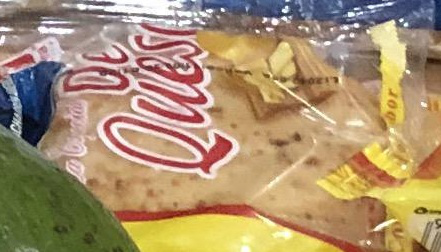

In [24]:
import json
from PIL import Image
#!curl "https://www.merkadomi.com/wp-content/uploads/2018/07/COCA-COLA-ORIGINAL-400ML.jpg" --output test.jpg
img_path = 'test13.jpg'
img = open_image(img_path)
pred_class,pred_idx,outputs = t_learner.predict(img)
print(pred_class, outputs[pred_idx].item())
print(json.dumps({"probabilities": {class_name: prob.item() 
                         for class_name, prob in zip(t_learner.data.classes, outputs)}}, indent=3))

#!rm test.jpg
img

In [7]:
t_learner.load(os.path.join(model_path,'teacher_stage-2'))

Learner(data=ImageDataBunch;

Train: LabelList (9996 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Valid: LabelList (2499 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mango_tommy,yogurt_alpina_finesse_frutos_rojosx180g,pan_de_queso_la_frontera,spagheti_barilla,maracuya
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padd

## Download data from S3

In [14]:
s3.Bucket(args.bucket_name).download_file(Key = os.path.join(args.key, args.data_dir, args.tar_file_name),
                                         Filename = os.path.join(args.root, args.data_dir, args.tar_file_name))
tarfile.open(os.path.join(args.root, args.data_dir, args.tar_file_name), "r:gz").extractall(
    os.path.join(args.root, args.data_dir)
)

In [ ]:
os.remove(os.path.join(args.root, args.data_dir, args.tar_file_name))

In [5]:
import fastai
fastai.__version__

'1.0.61'

## Loading data

In [6]:
model_path = os.path.join(args.root, args.model_dir)
data_path = Path(os.path.join(args.root, args.data_dir))
labels = os.listdir(data_path)

In [4]:
data = ImageDataLoaders.from_folder(data_path, valid_pct=0.2, bs=32, item_tfms=Resize(640), 
                    batch_tfms=[*aug_transforms(),Normalize.from_stats(*imagenet_stats)], num_workers=3)

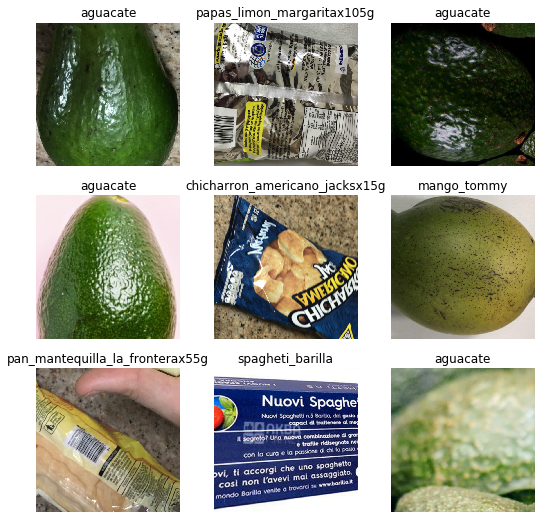

In [11]:
data.show_batch()

## Training pretrained model

In [6]:
learn = cnn_learner(data, resnet34, metrics=[error_rate,accuracy])

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.002511886414140463)

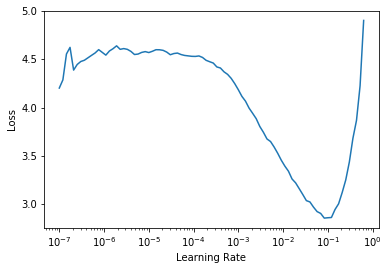

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(4,lr=7e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.524454,0.398595,0.138203,0.861797,04:35
1,0.650504,0.260971,0.080948,0.919052,04:06
2,0.412744,0.233161,0.078973,0.921027,04:08
3,0.335744,0.224722,0.076012,0.923988,04:07


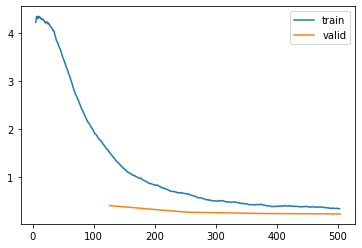

In [15]:
learn.recorder.plot_loss()

In [16]:
learn.save(os.path.join(model_path,'stage-1'))

In [17]:
learn.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=4.786300905834651e-06)

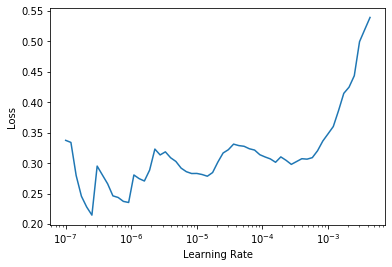

In [18]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(100,lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.359793,0.228673,0.072063,0.927937,05:30
1,0.296449,0.207853,0.072063,0.927937,05:30
2,0.280994,0.243464,0.077986,0.922014,05:32
3,0.257535,0.223040,0.065153,0.934847,05:31
4,0.285874,0.219996,0.081935,0.918065,05:30


In [ ]:
learn.recorder.summary()

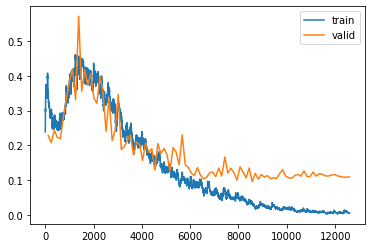

In [21]:
learn.recorder.plot_loss()

In [7]:
learn.load(os.path.join(model_path, 'stage-2'))

In [ ]:
learn.save(os.path.join(model_path, 'stage-2'))

In [20]:
model_path

'/home/ec2-user/SageMaker/classification_model/model'

In [28]:
learn.export(fname=os.path.join(model_path,'export_2.pkl'), pickle_protocol = 2)

## Interpretation

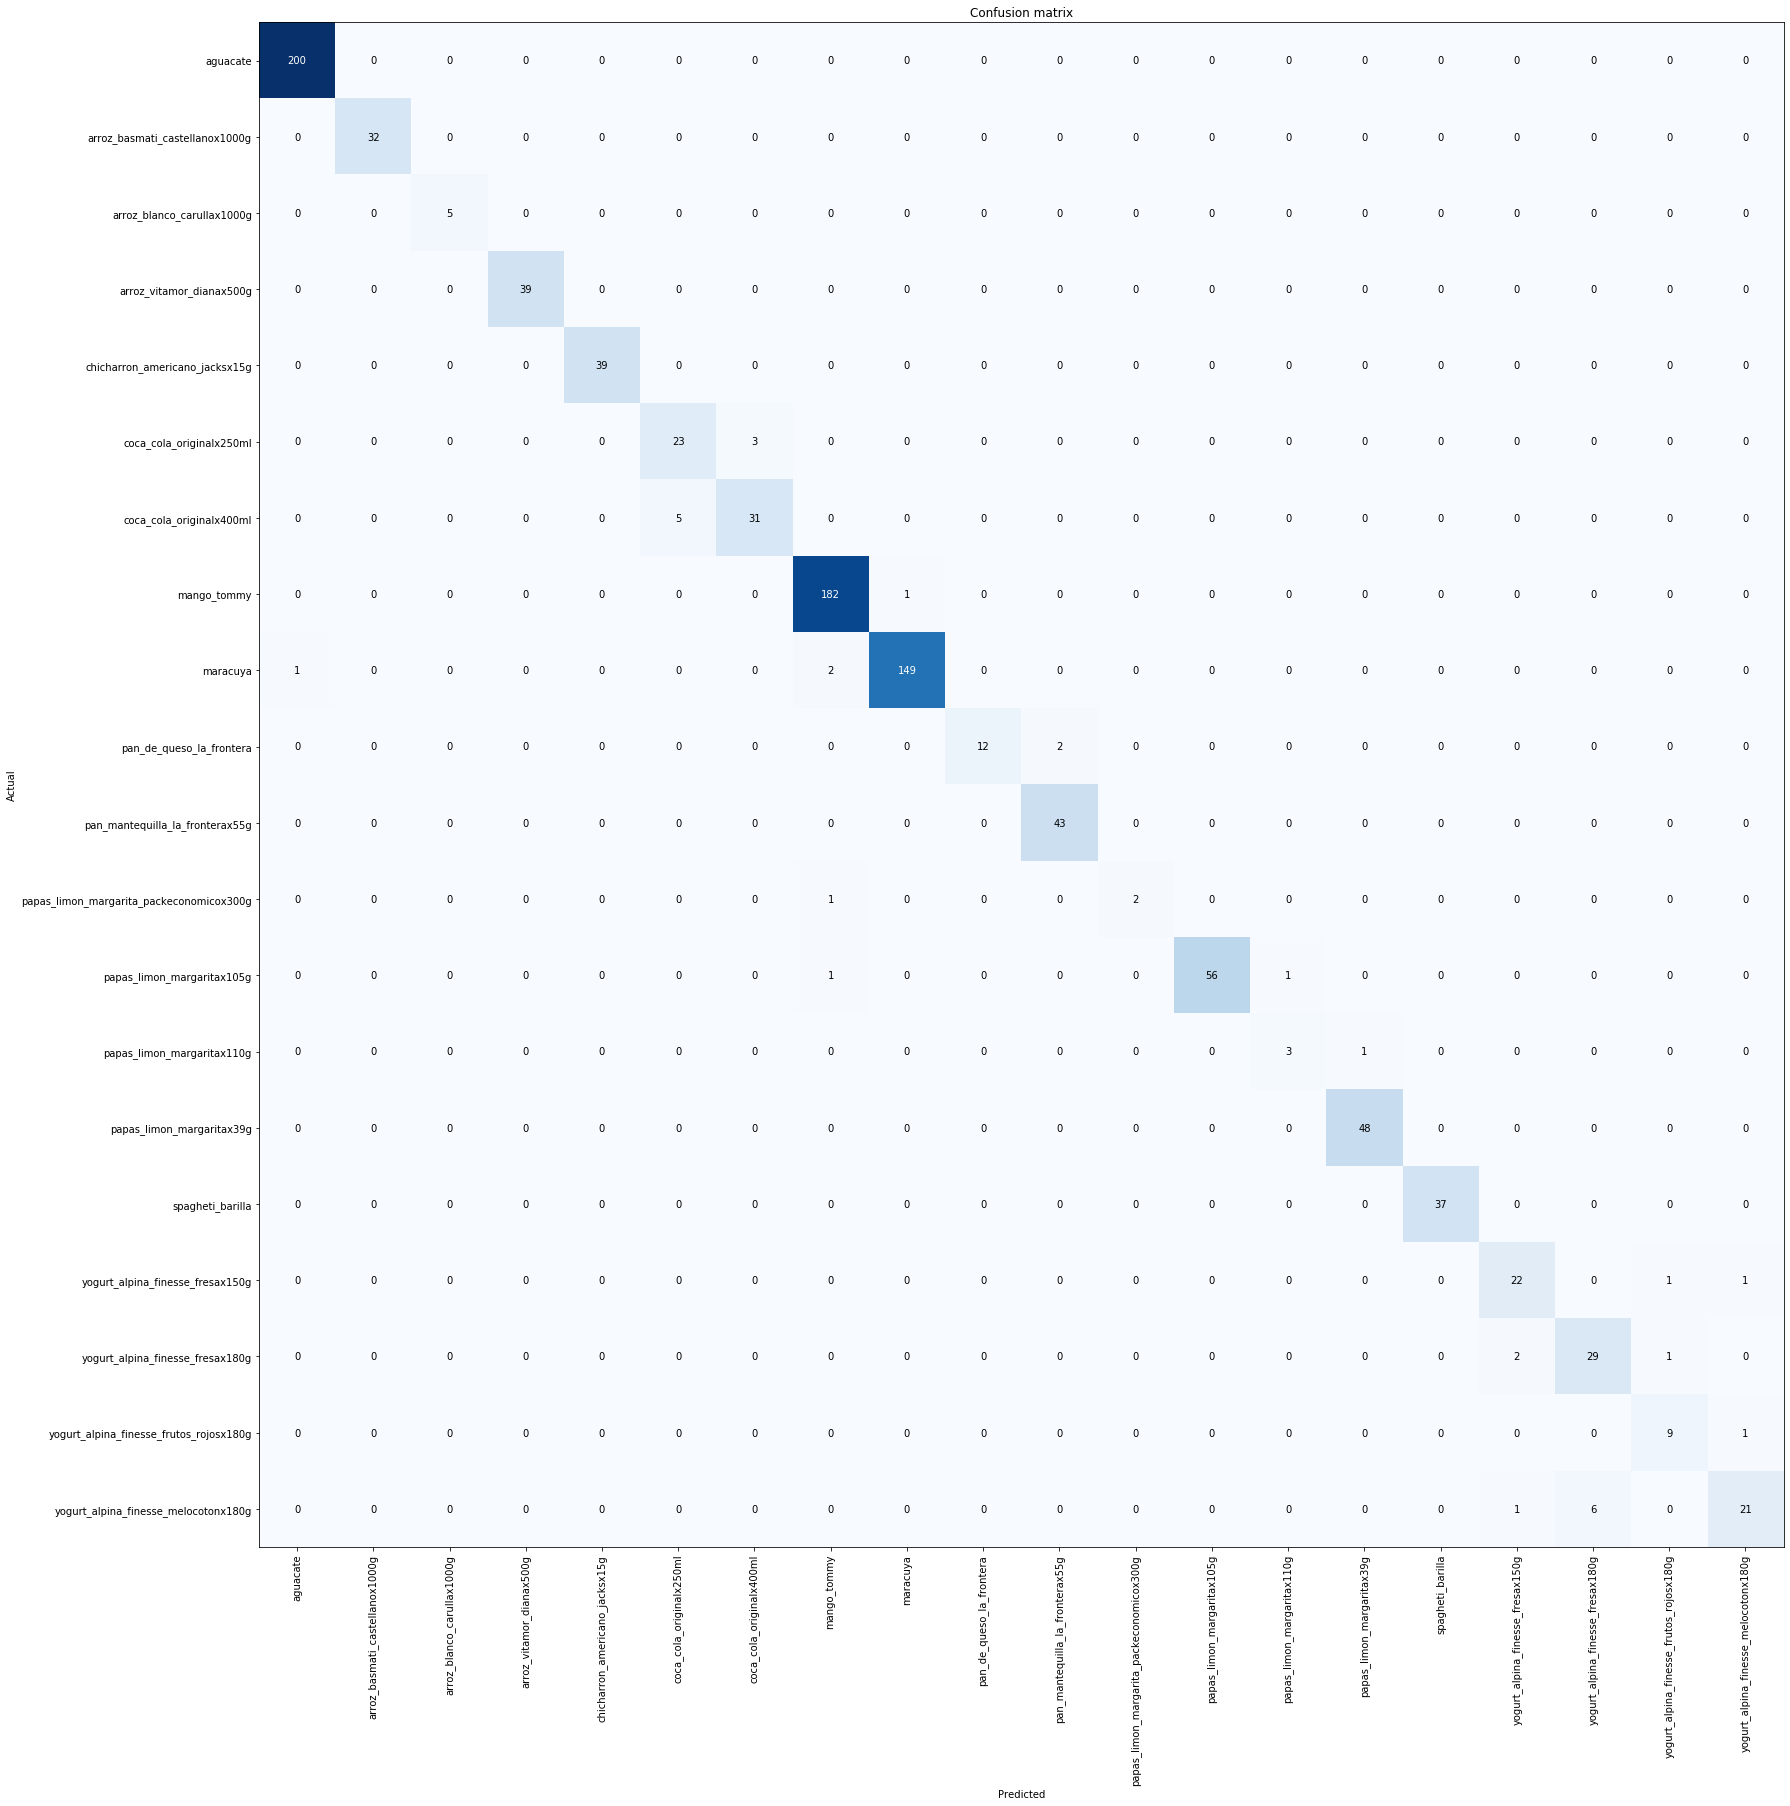

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(30,25))

## Prediction

arroz_vitamor_dianax500g 0.9995421171188354
{
   "probabilities": {
      "aguacate": 6.533402796549126e-08,
      "arroz_basmati_castellanox1000g": 2.467824742780067e-06,
      "arroz_blanco_carullax1000g": 8.09427092463011e-06,
      "arroz_vitamor_dianax500g": 0.9995421171188354,
      "chicharron_americano_jacksx15g": 5.803216822641843e-07,
      "coca_cola_originalx250ml": 2.4488112870812984e-08,
      "coca_cola_originalx400ml": 2.6456848445377545e-07,
      "mango_tommy": 5.007464096706826e-07,
      "maracuya": 1.9952743901541226e-09,
      "pan_de_queso_la_frontera": 1.4862618627375923e-05,
      "pan_mantequilla_la_fronterax55g": 0.00015052128583192825,
      "papas_limon_margarita_packeconomicox300g": 2.0487930669332854e-05,
      "papas_limon_margaritax105g": 4.831163913365799e-09,
      "papas_limon_margaritax110g": 3.856217153952457e-05,
      "papas_limon_margaritax39g": 0.00021975113486405462,
      "spagheti_barilla": 7.030690767351189e-07,
      "yogurt_alpina_finesse

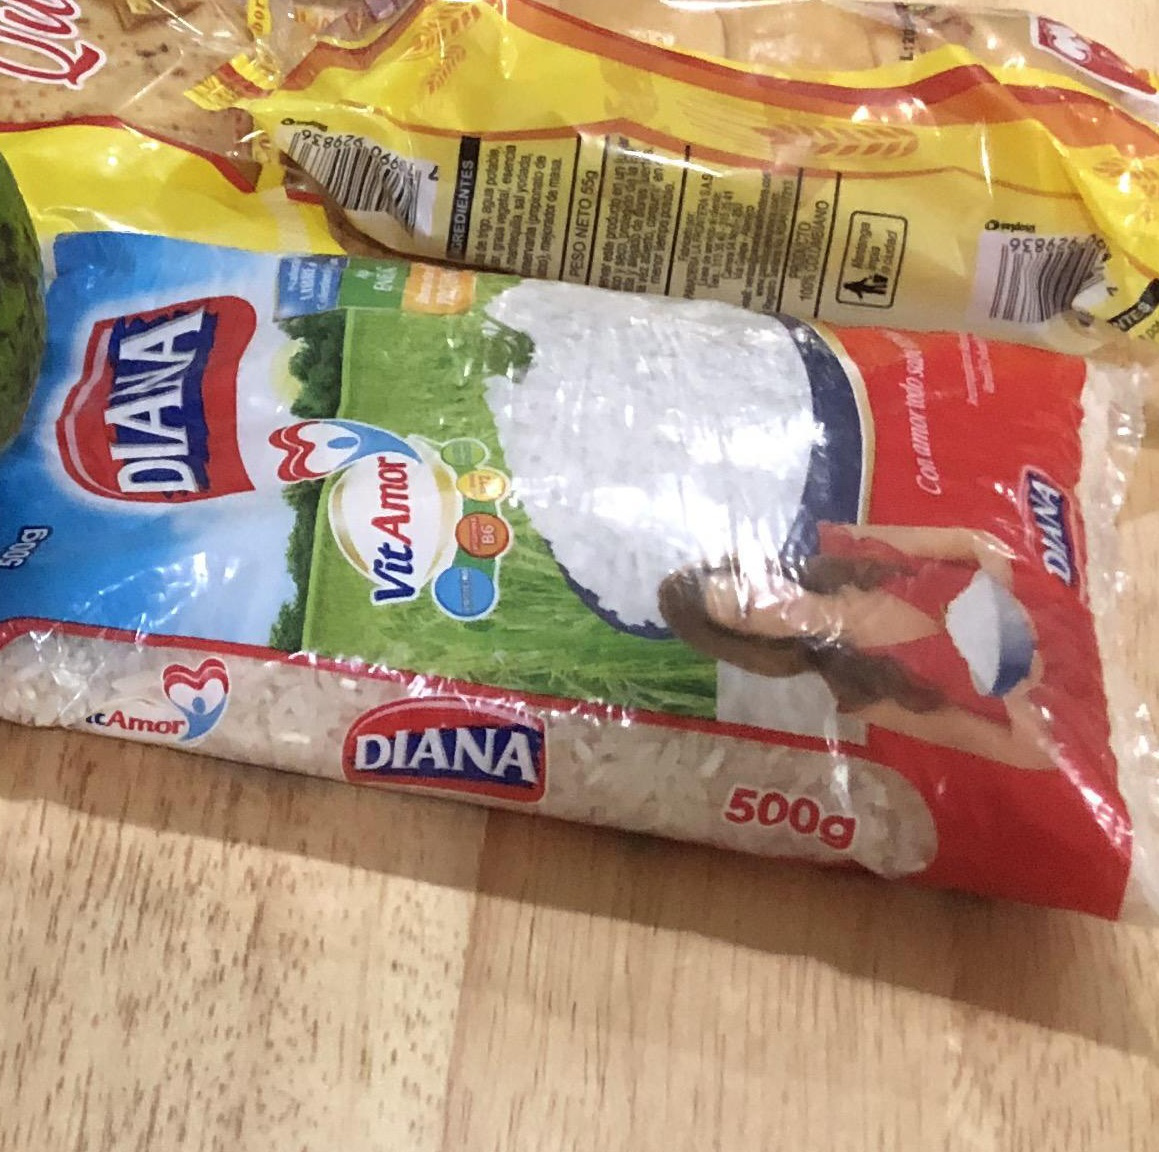

In [30]:
import json
from PIL import Image
#!curl "https://www.merkadomi.com/wp-content/uploads/2018/07/COCA-COLA-ORIGINAL-400ML.jpg" --output test.jpg
img_path = 'test5.jpg'
img = Image.open(img_path)
pred_class,pred_idx,outputs = learn.predict(img_path)
print(pred_class, outputs[pred_idx].item())
print(json.dumps({"probabilities": {class_name: prob.item() 
                         for class_name, prob in zip(data.vocab, outputs)}}, indent=3))

#!rm test.jpg
img

In [23]:
!pwd

/home/ec2-user/SageMaker/classification_model/src


In [23]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
    return output_filename

In [24]:
args.output_filename = make_tarfile(os.path.join(args.root, args.model_dir, args.tar_model_name), 
                                             os.path.join(args.root, args.model_dir))
s3.meta.client.upload_file(args.output_filename, Bucket=args.bucket_name, Key=os.path.join(args.key,
                                                                                         args.model_dir,
                                                                                         args.tar_model_name))
os.remove(args.output_filename)